In [35]:
import os
import sys
import random
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
import csv
from pickle import dump
from keras.utils.vis_utils import plot_model

random.seed(2)
random_state = 2

C:\Users\MacGy\AppData\Local\Temp\ipykernel_19048\2395792103.py:16: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [36]:
#WORKING DIRECTORY
#path = Path('/content/drive/MyDrive/Lab_mecc_H2O')
#save_path = Path(path / 'Nick_Ann_model_MLT_REALI')
path = Path.cwd()
save_path = Path(path / 'Ann_model_MLT')

parent_path =  path.parent

#DATA LOADING
data = pd.read_excel(parent_path / 'dataset\Simulated_Dataset.xlsx', header=1)

#variables to consider
feat = ['Influent Flow',
'Influent pH',
'Biofor DN Temperature',
'Biofor CN - Dissolved oxygen',
'Effluent Flow',
'Effluent pH']

targets = list(data.columns[-2:])

X = data[feat]
y = data[targets]

In [38]:
#PARAMETERS TO SET

Loss= {"COD": 'mean_squared_error',
       "TSS": 'mean_squared_error'}

lr=0.001

Optimizer= Adam(learning_rate=lr)
#Optimizer= SGD(learning_rate=lr)


epochs=1000
bs=128


In [39]:
#DEFINE NETWORK ARCHITECTURE FUNCTION
clear_session()

def ANN_AP(X,T,Loss,Optimizer):
    
    x = Input(shape=(X.shape[1], ))
    shared = Dense(32, activation='relu')(x)
    sub1 = Dense(16, activation='relu')(shared)
    sub2 = Dense(16, activation='relu')(shared)
    sub3 = Dense(16, activation='relu')(shared)
    sub1 = Dense(8, activation='relu')(sub1)
    sub2 = Dense(8, activation='relu')(sub2)
    sub3 = Dense(8, activation='relu')(sub3)
    out1 = Dense(1, name="BOD", activation='linear')(sub1)
    out2 = Dense(1, name="COD", activation='linear')(sub2)
    out3 = Dense(1, name="TSS", activation='linear')(sub3)

    model = Model(inputs=x, outputs=[out1, out2, out3])

    model.summary()
    
    model.compile(loss=Loss, optimizer=Optimizer, metrics=['MeanSquaredError','MeanAbsoluteError'])

    return model

In [40]:
#DEFINE NETWORK ARCHITECTURE FUNCTION
clear_session()

def ANN_AP(X,T,Loss,Optimizer):
    
    x = Input(shape=(X.shape[1], ))
    shared1 = Dense(256, activation='relu')(x)
    shared2 = Dense(256, activation='relu')(shared1)
    sub1 = Dense(128, activation='relu')(shared2)
    sub2 = Dense(128, activation='relu')(shared2)
    sub1 = Dense(64, activation='relu')(sub1)
    sub2 = Dense(64, activation='relu')(sub2)
    sub1 = Dense(32, activation='relu')(sub1)
    sub2 = Dense(32, activation='relu')(sub2)
    sub1 = Dense(16, activation='relu')(sub1)
    sub2 = Dense(16, activation='relu')(sub2)
    sub1 = Dense(8, activation='relu')(sub1)
    sub2 = Dense(8, activation='relu')(sub2)
    out1 = Dense(1, name="COD", activation='linear')(sub1)
    out2 = Dense(1, name="TSS", activation='linear')(sub2)

    model = Model(inputs=x, outputs=[out1, out2])

    model.summary()
    
    model.compile(loss=Loss, optimizer=Optimizer, metrics=['MeanSquaredError','MeanAbsoluteError'])

    return model

In [41]:
#SPLIT AND SCALE DATA
x_tv, x_test, y_tv, y_test = train_test_split(X, y, test_size=0.25, shuffle= True, random_state = random_state)
x_train, x_valid, y_train, y_valid = train_test_split(x_tv, y_tv, test_size=0.20, shuffle= True, random_state = random_state)
print(x_train.shape, x_valid.shape, x_test.shape)

# Transform
ss = StandardScaler()
ss.fit(x_train)
x_train_scaled = ss.transform(x_train)
x_valid_scaled = ss.transform(x_valid)
x_test_scaled  = ss.transform(x_test)

# save the scaler
dump(ss, open(save_path / 'scaler_MLT.pkl', 'wb'))

(5184, 6) (1296, 6) (2160, 6)


In [42]:
#CALL AND TRAIN NETWORK
NeuNet = ANN_AP(X,y,Loss,Optimizer)

es = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
history = NeuNet.fit(x_train_scaled, y={"COD": y_train.iloc[:,0],"TSS": y_train.iloc[:,1]}, 
                     validation_data = (x_valid_scaled,{"COD": y_valid.iloc[:,0],"TSS": y_valid.iloc[:,1]}), 
                     epochs=epochs, batch_size=bs, verbose=1, callbacks=[es])

#Save trained model
NeuNet.save(save_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          1792        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          32896       ['dense_1[0][0]']                
                                                                                              

INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_MLT\assets


INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_MLT\assets


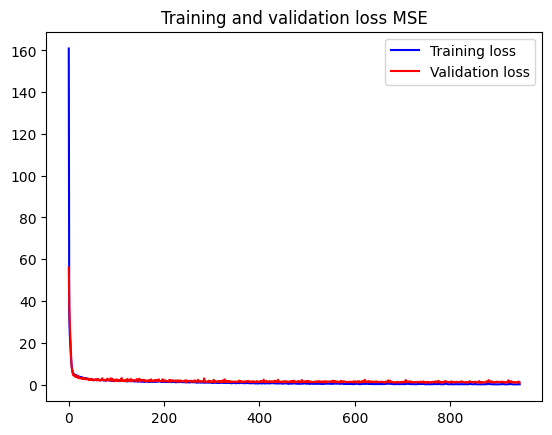

In [43]:
#PLOT TRAINING CURVES
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss MSE')
plt.legend()


In [44]:
#If we want to reload a trainend model
NeuNet = tf.keras.models.load_model(save_path)

In [45]:
plot_model(NeuNet, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
#Export metrics on CSV

with open(save_path / 'Metrics.csv', "w") as f:
  fieldnames = ['Variable','CC','RMSE','SI','BIAS','MeanAPD','StdAPD']
  writer = csv.DictWriter(f, fieldnames=fieldnames)
  writer.writeheader()

In [47]:
from tensorflow.keras.callbacks import Callback
import time
class PredictionCallback(Callback):
    start_time = time.time()
    
    def on_predict_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting prediction ...")
    
    def on_predict_end(self, logs=None):
        end_time = time.time()-self.start_time
        print(f"Inference time: {end_time} seconds")

Starting prediction ...
68/68 [==============================] - 0s 1ms/step

    ----------------------------------------
    # Variable: Effluent COD
    # CC: PearsonRResult(statistic=0.9914381965140369, pvalue=0.0)
    # RMSE: 1.0103979746220721
    # SI: 0.06287774658364813
    # BIAS: -0.03144677952156253
    # MeanAPD: 2.2806077197136876
    # StdAPD: 3.28528826713727
    
    ----------------------------------------
    

    ----------------------------------------
    # Variable: Effluent Total suspended solids
    # CC: PearsonRResult(statistic=0.9966518906940945, pvalue=0.0)
    # RMSE: 0.12044015732177937
    # SI: 0.018675776794761543
    # BIAS: 0.005855513111952041
    # MeanAPD: 1.122085171868472
    # StdAPD: 1.5179026790763959
    
    ----------------------------------------
    


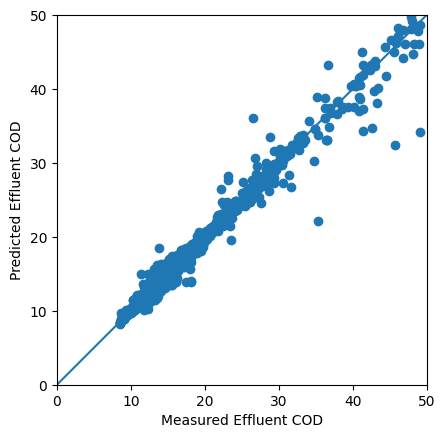

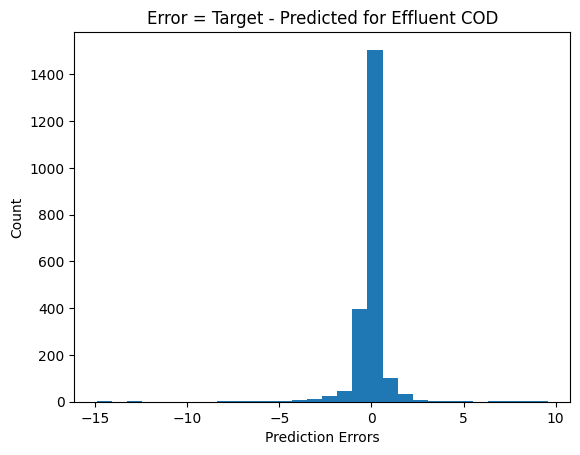

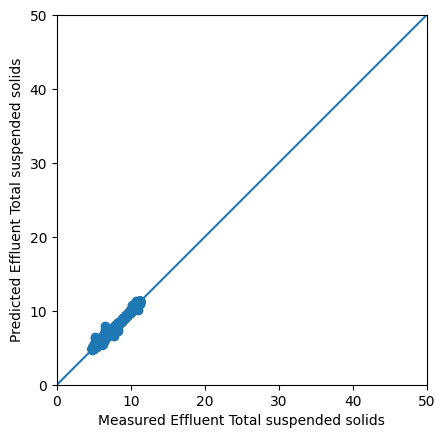

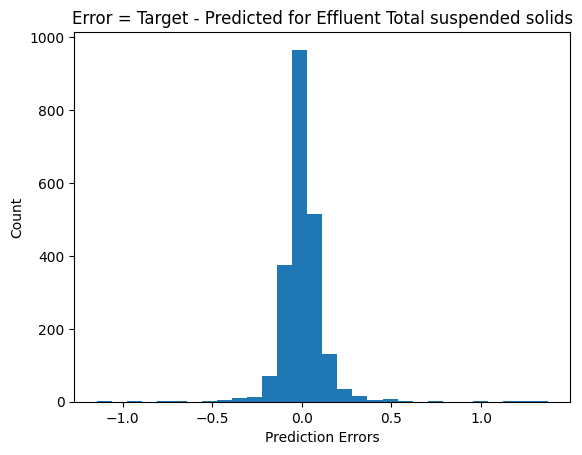

In [48]:
#INFERENCE ON TEST SET

# make predictions on the testing data
preds = NeuNet.predict(x_test_scaled,callbacks=PredictionCallback())

for i in range(0,len(targets)):
    
    name = targets[i]
    
    pred = preds[i].flatten()
    y_test_var = y_test.iloc[:,i]
    
    diff = pred - y_test_var
    percentDiff = (diff / y_test_var) * 100
    
    #METRICS
    AbsPercentDiff = np.abs(percentDiff)
    MeanAPD = np.mean(AbsPercentDiff)
    StdAPD = np.std(AbsPercentDiff)
    
    CCTest  = pearsonr(y_test_var,pred)   #it should be the same thing of MATLAB 'corr' 
    RmseTest  = sqrt(mean_squared_error(y_test_var,pred))
    SITest  = sqrt(mean_squared_error(y_test_var,pred))/np.mean(y_test_var)
    BiasTest  = np.sum(pred-y_test_var)/y_test_var.shape[0]

    s = f"""
    {'-'*40}
    # Variable: {name}
    # CC: {CCTest}
    # RMSE: {RmseTest}
    # SI: {SITest}
    # BIAS: {BiasTest}
    # MeanAPD: {MeanAPD}
    # StdAPD: {StdAPD}
    
    {'-'*40}
    """
    
    print(s)
    
    #Export metrics on CSV
    
    with open(save_path / 'Metrics.csv', "a") as f:
      writer = csv.DictWriter(f, fieldnames=fieldnames)
      writer.writerow({'Variable':name,'CC':CCTest,'RMSE':RmseTest,'SI':SITest,
                       'BIAS':BiasTest,'MeanAPD':MeanAPD,'StdAPD':StdAPD})
    plt.figure()
    a = plt.axes(aspect='equal')
    plt.scatter(y_test_var, pred)
    plt.xlabel('Measured '+name)
    plt.ylabel('Predicted '+name)
    lims = [0, 50]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
    plt.figure()
    plt.hist(diff, bins=30)
    plt.title('Error = Target - Predicted for '+name)
    plt.xlabel('Prediction Errors')
    _ = plt.ylabel('Count')

In [49]:
data2 = pd.read_excel(parent_path / 'dataset\Simulated_Dataset.xlsx','Faults', usecols='A:P')
data3=data2
data3=data3.dropna()
data3 

,Unnamed: 0,Date,Influent Flow,Influent pH,Influent NNH4,Influent PPO4,Biofor DN Temperature,Biofor CN - Dissolved oxygen,Effluent Flow,Effluent pH,Effluent NNH4,Effluent NNOx,Effluent PPO4,Effluent BOD,Effluent COD,Effluent Total suspended solids
0,"SCENARIO Q_0_5 JULY: Aeration = 0 for 2 days, ...",2020-07-05 12:00:00,80841.84648,7.785700,14.150475,0.972406,22.520732,5.584665,79346.52648,7.046615,0.303810,5.082537,0.507021,4.154902,12.822675,5.845858
88,SCENARIO Q_50_7 JULY: Aeration = -50% for 15 d...,2020-07-05 12:00:00,80841.84648,7.785662,14.149200,0.970000,22.520732,5.584605,79346.52648,7.046644,0.303764,5.082487,0.502080,4.154553,12.822283,5.844469
450,SCENARIO Q_ma_6 JULY: Internal recycle = 0 for...,2020-07-05 12:00:00,80841.84648,7.785662,14.149200,0.970000,22.520732,5.584605,79346.52648,7.046644,0.303764,5.082487,0.502080,4.154553,12.822283,5.844469
605,SCENARIO Q_b_1 JULY: Bacwash flow = 0 for 2 da...,2020-07-05 12:00:00,80841.84648,7.785700,14.150475,0.972406,22.520732,5.584665,79346.52648,7.046615,0.303810,5.082537,0.507021,4.154902,12.822675,5.845858
654,SCENARIO Q_0_5 JANUARY: Aeration = 0 for 2 day...,2020-01-05 12:00:00,75447.29146,7.599920,18.276848,1.292741,13.607784,4.930589,73951.97146,6.952141,0.485328,7.157517,0.801950,3.842954,13.255998,5.503082
739,SCENARIO Q_50_7 JANUARY: Aeration = -50% for 1...,2020-01-05 12:00:00,75447.29146,7.599920,18.276848,1.292741,13.607784,4.930825,73951.97146,6.952152,0.485327,7.157538,0.800901,3.842953,13.255973,5.502707
1107,SCENARIO Q_ma_6 JANUARY: Internal recycle = 0 ...,2020-01-05 12:00:00,75447.29146,7.599920,18.276848,1.292741,13.607784,4.930826,73951.97146,6.952152,0.485327,7.157538,0.800901,3.842953,13.255973,5.502707
1274,SCENARIO Q_b_1 JANUARY: Bacwash flow = 0 for 2...,2020-01-05 12:00:00,75447.29146,7.599920,18.276848,1.292741,13.607784,4.930826,73951.97146,6.952151,0.485326,7.157538,0.800902,3.842954,13.255975,5.502707


In [50]:
X2 = data2[feat]
x2_scaled = ss.transform(X2)

y2 = data2[targets]

Starting prediction ...
42/42 [==============================] - 0s 1ms/step

    ----------------------------------------
    # Variable: Effluent COD
    # CC: PearsonRResult(statistic=0.7987635057797967, pvalue=8.86089528461802e-294)
    # RMSE: 73.1355851295926
    # SI: 3.7469278503019847
    # BIAS: 35.25547578412614
    # MeanAPD: 166.50303737761445
    # StdAPD: 134.30388630080657
    
    ----------------------------------------
    

    ----------------------------------------
    # Variable: Effluent Total suspended solids
    # CC: PearsonRResult(statistic=-0.2307245051049776, pvalue=1.9098200791301128e-17)
    # RMSE: 9.998496990057989
    # SI: 1.383874751826319
    # BIAS: 4.283656948484031
    # MeanAPD: 112.52310650011091
    # StdAPD: 120.22801774846909
    
    ----------------------------------------
    


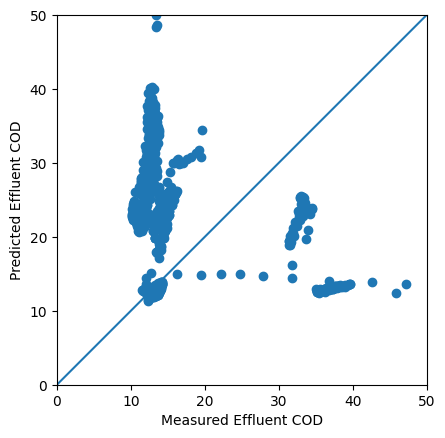

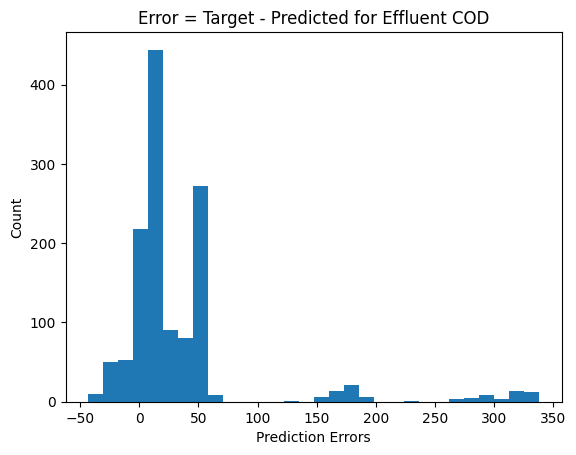

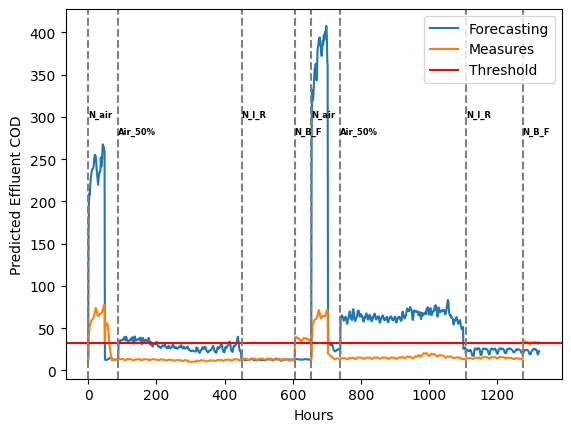

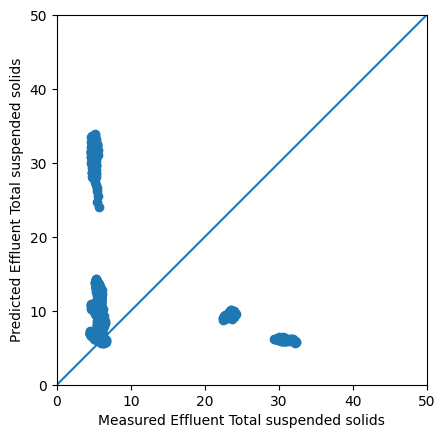

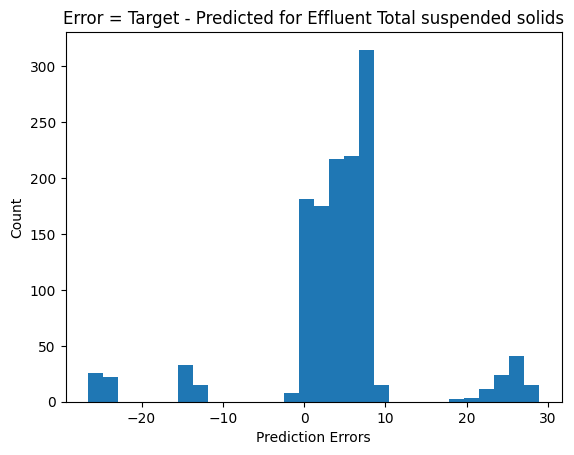

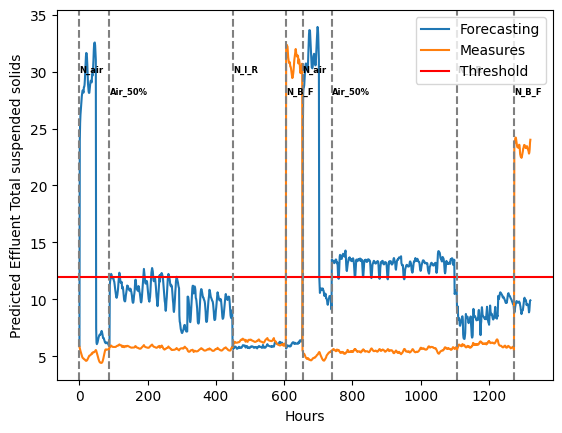

In [51]:
#INFERENCE ON TEST SET

# make predictions on the testing data
preds = NeuNet.predict(x2_scaled,callbacks=PredictionCallback())
fault=['N_air','Air_50%','N_I_R','N_B_F','N_air','Air_50%','N_I_R','N_B_F']
for i in range(0,len(targets)):
    
    name = targets[i]
    
    pred = preds[i].flatten()
    y_test_var = y2.iloc[:,i
    ]
    
    diff = pred - y_test_var
    percentDiff = (diff / y_test_var) * 100
    
    #METRICS
    AbsPercentDiff = np.abs(percentDiff)
    MeanAPD = np.mean(AbsPercentDiff)
    StdAPD = np.std(AbsPercentDiff)
    
    CCTest  = pearsonr(y_test_var,pred)   #it should be the same thing of MATLAB 'corr' 
    RmseTest  = sqrt(mean_squared_error(y_test_var,pred))
    SITest  = sqrt(mean_squared_error(y_test_var,pred))/np.mean(y_test_var)
    BiasTest  = np.sum(pred-y_test_var)/y_test_var.shape[0]

    s = f"""
    {'-'*40}
    # Variable: {name}
    # CC: {CCTest}
    # RMSE: {RmseTest}
    # SI: {SITest}
    # BIAS: {BiasTest}
    # MeanAPD: {MeanAPD}
    # StdAPD: {StdAPD}
    
    {'-'*40}
    """
    
    print(s)
    
    #Export metrics on CSV
    
    with open(save_path / 'Metrics.csv', "a") as f:
      writer = csv.DictWriter(f, fieldnames=fieldnames)
      writer.writerow({'Variable':name,'CC':CCTest,'RMSE':RmseTest,'SI':SITest,
                       'BIAS':BiasTest,'MeanAPD':MeanAPD,'StdAPD':StdAPD})
    plt.figure()
    a = plt.axes(aspect='equal')
    plt.scatter(y_test_var, pred)
    plt.xlabel('Measured '+name)
    plt.ylabel('Predicted '+name)
    lims = [0, 50]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
    plt.figure()
    plt.hist(diff, bins=30)
    plt.title('Error = Target - Predicted for '+name)
    plt.xlabel('Prediction Errors')
    _ = plt.ylabel('Count')

    plt.figure()
    plt.plot(pred,label='Forecasting')
    plt.plot(y_test_var,label='Measures')
    media=[16,6]
    plt.axhline(y=2*media[i], color='red', label='Threshold')
    Testo=[300,30]
    alzata=[[0,-20,0,-20,0,-20,0,-20,0,-20],[0,-2,0,-2,0,-2,0,-2,0,-2]]
    k=0
    plt.legend()
    plt.ylabel('Predicted '+name)
    plt.xlabel('Hours')

    for j in data3.index:
      plt.axvline(x=j, color='gray', linestyle='--')
      plt.text(j, Testo[i]+alzata[i][k], fault[k], fontsize = 6,weight='bold')
      k=k+1



In [52]:
data3.index

Index([0, 88, 450, 605, 654, 739, 1107, 1274], dtype='int64')